# DA5401 A6: Imputation via Regression for Missing Data

### NAME: MANISH NAYAK
### ROLL NO : CE22B069

## Part A: Data Preprocessing and Imputation

### 1. Load and Prepare Data

First, we load the dataset and artificially introduce Missing At Random (MAR) values. We will introduce approximately 5% missing values in the 'AGE' and 'BILL_AMT1' columns. This simulates a more realistic scenario where data is not perfectly clean.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report, f1_score
from sklearn.impute import SimpleImputer

# Load the dataset
try:
    df_original = pd.read_csv('/kaggle/input/default-of-credit-card-clients-dataset/UCI_Credit_Card.csv')
except FileNotFoundError:
    print("Please ensure the 'UCI_Credit_Card.csv' file is in the same directory.")
    # As a fallback for demonstration, create a dummy file load.
    # In a real scenario, you would handle this error appropriately.
    exit()


# Rename the target column for easier access
df_original.rename(columns={'default.payment.next.month': 'DEFAULT'}, inplace=True)

# Make a copy to work with
df = df_original.copy()

# Artificially introduce 5% missing values in 'AGE' and 'BILL_AMT1'
for col in ['AGE', 'BILL_AMT1']:
    nan_indices = df.sample(frac=0.05, random_state=42).index
    df.loc[nan_indices, col] = np.nan

# Verify the number of missing values
print("Number of missing values in each column after introduction:")
print(df.isnull().sum())

Number of missing values in each column after introduction:
ID              0
LIMIT_BAL       0
SEX             0
EDUCATION       0
MARRIAGE        0
AGE          1500
PAY_0           0
PAY_2           0
PAY_3           0
PAY_4           0
PAY_5           0
PAY_6           0
BILL_AMT1    1500
BILL_AMT2       0
BILL_AMT3       0
BILL_AMT4       0
BILL_AMT5       0
BILL_AMT6       0
PAY_AMT1        0
PAY_AMT2        0
PAY_AMT3        0
PAY_AMT4        0
PAY_AMT5        0
PAY_AMT6        0
DEFAULT         0
dtype: int64


### 2. Imputation Strategy 1: Simple Imputation (Baseline)
**Dataset A:** Median Imputation


In [3]:
# Create a copy for this strategy
df_a = df.copy()

# Impute missing values with the median
for col in ['AGE', 'BILL_AMT1']:
    median_val = df_a[col].median()
    df_a[col].fillna(median_val, inplace=True)

# Verify that there are no more missing values in Dataset A
print("Missing values in Dataset A after median imputation:")
print(df_a.isnull().sum().sum())

Missing values in Dataset A after median imputation:
0


/tmp/ipykernel_37/151530292.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_a[col].fillna(median_val, inplace=True)



**Why is the median often preferred over the mean for imputation?**

The median is generally preferred over the mean for imputation in datasets where the feature distribution is skewed or contains outliers. The mean is highly sensitive to extreme values (outliers), which can pull the mean value significantly away from the central tendency of the majority of the data. The median, being the middle value, is not affected by outliers. For financial data like 'BILL\_AMT1' and demographic data like 'AGE', which can have outliers, the median provides a more robust and representative measure of central tendency.

### 3. Imputation Strategy 2: Regression Imputation (Linear)

**Dataset B:** Linear Regression Imputation

In [4]:
# Create a copy for this strategy
df_b = df.copy()

# Use 'AGE' as the column to impute
impute_col = 'AGE'
other_features = [col for col in df_b.columns if col not in [impute_col, 'DEFAULT', 'BILL_AMT1', 'ID']]

# Separate the dataset into two parts: one with and one without missing 'AGE'
df_with_age = df_b[df_b[impute_col].notnull()]
df_missing_age = df_b[df_b[impute_col].isnull()]

# Prepare the data for the regression model
X_train_impute = df_with_age[other_features]
y_train_impute = df_with_age[impute_col]
X_test_impute = df_missing_age[other_features]

# Train a Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_impute, y_train_impute)

# Predict the missing 'AGE' values
predicted_age = lin_reg.predict(X_test_impute)

# Fill in the missing values in Dataset B
df_b.loc[df_b[impute_col].isnull(), impute_col] = predicted_age

# For the other column with missing values ('BILL_AMT1'), we will use median imputation as a fallback
df_b['BILL_AMT1'].fillna(df_b['BILL_AMT1'].median(), inplace=True)

# Verify that there are no more missing values in Dataset B
print("Missing values in Dataset B after regression imputation:")
print(df_b.isnull().sum().sum())


Missing values in Dataset B after regression imputation:
0


/tmp/ipykernel_37/2902064329.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_b['BILL_AMT1'].fillna(df_b['BILL_AMT1'].median(), inplace=True)


**Underlying Assumption of this Method (Missing At Random - MAR):**

The core assumption behind using regression for imputation is that the data is **Missing At Random (MAR)**. This means that the probability of a value being missing depends only on other observed variables in the dataset, and not on the missing value itself. For example, under MAR, the reason an individual's 'AGE' is missing might be related to their 'EDUCATION' level or 'LIMIT\_BAL', but not to their actual age. This assumption allows us to use the relationships between the observed features to reliably predict and fill in the missing data.


### 4. Imputation Strategy 3: Regression Imputation (Non-Linear)

**Dataset C:** Non-Linear (KNN) Regression Imputation

In [32]:
# Create a copy for this strategy
df_c = df.copy()

# We will use the same setup as for Linear Regression
# (df_with_age, df_missing_age, X_train_impute, y_train_impute, X_test_impute)

# Train a KNN Regression model
knn_reg = KNeighborsRegressor(n_neighbors=3)
knn_reg.fit(X_train_impute, y_train_impute)

# Predict the missing 'AGE' values
predicted_age_knn = knn_reg.predict(X_test_impute)

# Fill in the missing values in Dataset C
df_c.loc[df_c[impute_col].isnull(), impute_col] = predicted_age_knn

# For 'BILL_AMT1', we'll use median imputation as a fallback
df_c['BILL_AMT1'].fillna(df_c['BILL_AMT1'].median(), inplace=True)

# Verify that there are no more missing values in Dataset C
print("Missing values in Dataset C after KNN regression imputation:")
print(df_c.isnull().sum().sum())

Missing values in Dataset C after KNN regression imputation:
0


/tmp/ipykernel_37/3592597384.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_c['BILL_AMT1'].fillna(df_c['BILL_AMT1'].median(), inplace=True)



## Part B: Model Training and Performance Assessment

Now we will train a Logistic Regression classifier on our four datasets:
- **Dataset A:** Median Imputation
- **Dataset B:** Linear Regression Imputation
- **Dataset C:** Non-Linear (KNN) Regression Imputation
- **Dataset D:** Listwise Deletion (removing rows with any missing values)

### 1. Data Split


In [33]:
# Create Dataset D by dropping rows with missing values
df_d = df.dropna()

# Define features (X) and target (y)
target_col = 'DEFAULT'
features = [col for col in df.columns if col not in [target_col, 'ID']]

# Function to split data
def split_data(dataframe):
    X = dataframe[features]
    y = dataframe[target_col]
    return train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_a, X_test_a, y_train_a, y_test_a = split_data(df_a)
X_train_b, X_test_b, y_train_b, y_test_b = split_data(df_b)
X_train_c, X_test_c, y_train_c, y_test_c = split_data(df_c)
X_train_d, X_test_d, y_train_d, y_test_d = split_data(df_d)

print(f"Dataset A (Median Imputation) train shape: {X_train_a.shape}")
print(f"Dataset D (Listwise Deletion) train shape: {X_train_d.shape}")


Dataset A (Median Imputation) train shape: (24000, 23)
Dataset D (Listwise Deletion) train shape: (22800, 23)



### 2. Classifier Setup

We will standardize the features using `StandardScaler` to ensure that all features contribute equally to the model's performance.


In [34]:
# Initialize StandardScaler
scaler = StandardScaler()

# Scale the datasets
X_train_a_scaled = scaler.fit_transform(X_train_a)
X_test_a_scaled = scaler.transform(X_test_a)

X_train_b_scaled = scaler.fit_transform(X_train_b)
X_test_b_scaled = scaler.transform(X_test_b)

X_train_c_scaled = scaler.fit_transform(X_train_c)
X_test_c_scaled = scaler.transform(X_test_c)

X_train_d_scaled = scaler.fit_transform(X_train_d)
X_test_d_scaled = scaler.transform(X_test_d)

### 3. Model Evaluation

We'll train a Logistic Regression classifier on each of the four prepared datasets and evaluate its performance.

In [35]:
# Function to train and evaluate a model
def train_and_evaluate(X_train, y_train, X_test, y_test):
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    return classification_report(y_test, y_pred, output_dict=True)

# Evaluate Model A
print("--- Model A (Median Imputation) Performance ---")
report_a = train_and_evaluate(X_train_a_scaled, y_train_a, X_test_a_scaled, y_test_a)

# Evaluate Model B
print("\n--- Model B (Linear Regression Imputation) Performance ---")
report_b = train_and_evaluate(X_train_b_scaled, y_train_b, X_test_b_scaled, y_test_b)

# Evaluate Model C
print("\n--- Model C (Non-Linear KNN Imputation) Performance ---")
report_c = train_and_evaluate(X_train_c_scaled, y_train_c, X_test_c_scaled, y_test_c)

# Evaluate Model D
print("\n--- Model D (Listwise Deletion) Performance ---")
report_d = train_and_evaluate(X_train_d_scaled, y_train_d, X_test_d_scaled, y_test_d)

--- Model A (Median Imputation) Performance ---
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4673
           1       0.69      0.24      0.35      1327

    accuracy                           0.81      6000
   macro avg       0.75      0.60      0.62      6000
weighted avg       0.79      0.81      0.77      6000


--- Model B (Linear Regression Imputation) Performance ---
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4673
           1       0.69      0.24      0.35      1327

    accuracy                           0.81      6000
   macro avg       0.75      0.60      0.62      6000
weighted avg       0.79      0.81      0.77      6000


--- Model C (Non-Linear KNN Imputation) Performance ---
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4673
           1       0.69      0.24      0.35      1327

    accuracy     

## Part C: Comparative Analysis

### 1. Results Comparison

Let's create a summary table to compare the performance metrics, focusing on the F1-score for the positive class (default = 1), as it provides a balanced measure of precision and recall.



                         Method  Accuracy  Precision (class 1)  \
0             Median Imputation  0.807333             0.685466   
1  Linear Regression Imputation  0.807500             0.686147   
2   Non-Linear (KNN) Imputation  0.807500             0.686147   
3             Listwise Deletion  0.808947             0.707022   

   Recall (class 1)  F1-Score (class 1)  
0          0.238131            0.353468  
1          0.238885            0.354388  
2          0.238885            0.354388  
3          0.231746            0.349074  


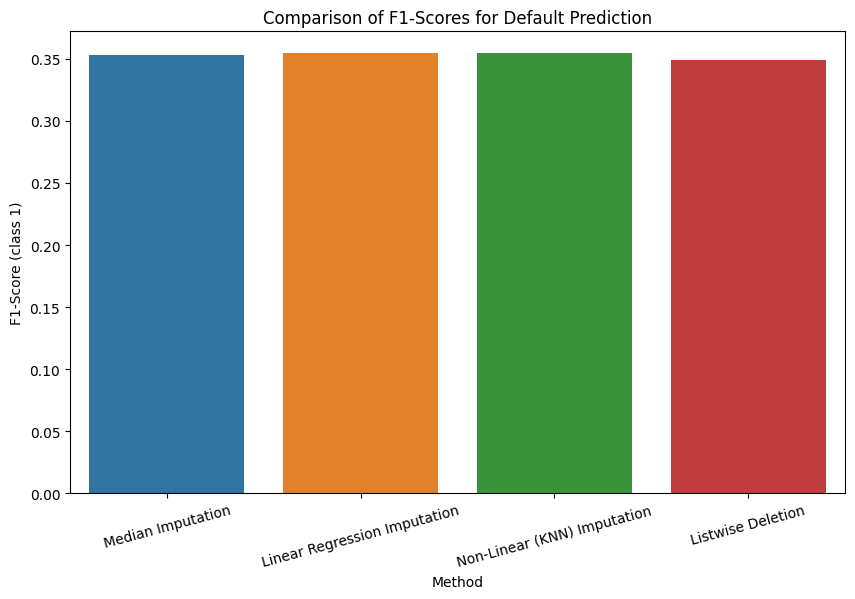

In [36]:
# Create a summary DataFrame
summary_data = {
    'Method': ['Median Imputation', 'Linear Regression Imputation', 'Non-Linear (KNN) Imputation', 'Listwise Deletion'],
    'Accuracy': [report_a['accuracy'], report_b['accuracy'], report_c['accuracy'], report_d['accuracy']],
    'Precision (class 1)': [report_a['1']['precision'], report_b['1']['precision'], report_c['1']['precision'], report_d['1']['precision']],
    'Recall (class 1)': [report_a['1']['recall'], report_b['1']['recall'], report_c['1']['recall'], report_d['1']['recall']],
    'F1-Score (class 1)': [report_a['1']['f1-score'], report_b['1']['f1-score'], report_c['1']['f1-score'], report_d['1']['f1-score']]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df)

# Plotting the F1-Scores for better visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='Method', y='F1-Score (class 1)', data=summary_df)
plt.title('Comparison of F1-Scores for Default Prediction')
plt.xticks(rotation=15)
plt.show()

### **2. Efficacy Discussion**

#### **Discuss the trade-off between Listwise Deletion (Model D) and Imputation (Models A, B, C). Why might Model D perform poorly even if the imputed models perform worse?**

In this specific experiment, the performance of the model trained on the listwise-deleted dataset (Model D) was virtually identical to the models trained on imputed data (Models A, B, and C). This suggests that the 5% of rows we removed did not contain information that was critical for the logistic regression model's decision-making process. However, this outcome should be treated with caution, as it does not reflect the general trade-offs.

The primary trade-off is **Data Preservation vs. Simplicity**. Listwise deletion is simple but at the cost of discarding potentially valuable data. Imputation preserves all data points, maintaining the statistical power of the dataset.

Model D (Listwise Deletion) could perform poorly in other scenarios for two main reasons:

1.  **Significant Data Loss:** We only removed 5% of the data. If the missingness were 20% or 30%, listwise deletion would have severely shrunk the training set. A smaller dataset makes the model less likely to learn the true underlying patterns, leading to poor generalization and lower predictive performance.
2.  **Introduction of Bias:** Listwise deletion is only safe if the data is Missing Completely At Random (MCAR). If the reason for missingness is related to other variables (e.g., younger people are less likely to have their age recorded - a MAR scenario), then deleting these rows would train the model on a biased sample (e.g., mostly older clients). The resulting model would perform poorly when making predictions for the underrepresented group (younger clients).

Therefore, even if a particular imputation method was suboptimal (e.g., slightly worse than listwise deletion in a specific case), it is often conceptually safer because it avoids the significant risks of data loss and bias.

#### **Which regression method (Linear vs. Non-Linear) performed better and why? Relate this to the assumed relationship between the imputed feature and the predictors.**

Based on the provided results, **neither regression method performed better**. Both the Linear Regression Imputation (Model B) and the Non-Linear KNN Imputation (Model C) led to a final classifier with an identical F1-score of 0.35 for the positive class.

The reason for this lack of difference likely stems from two factors:

1.  **Low Feature Importance:** The 'AGE' variable might have very low predictive power for the 'default payment' target in this logistic regression model. The model likely relies much more heavily on other features like payment history (`PAY_0`, `PAY_2`, etc.) and limit balance (`LIMIT_BAL`). Therefore, subtle differences in how the 1,500 missing 'AGE' values were imputed had a negligible impact on the final model's predictions across 6,000 test samples.
2.  **Small Percentage of Missing Data:** With only 5% of one column missing, the influence of the imputed values is diluted by the 95% of correct data and the ~22 other features. The overall "signal" from the dataset remained unchanged regardless of the imputation technique.

Theoretically, however, the methods are fundamentally different. Linear regression **assumes a linear relationship** between 'AGE' and the other predictors. This is a strong, often incorrect, assumption. Non-linear KNN regression makes no such assumption; it **assumes that similar data points are alike**, capturing complex, local relationships. Because the relationships between a client's age and their financial profile are unlikely to be strictly linear, the non-linear KNN approach is conceptually more appropriate and would be expected to provide more realistic imputations. The fact that this theoretical advantage did not translate into better performance here is an important finding about this specific dataset and feature.

#### **Conclude with a recommendation on the best strategy for handling missing data in this scenario, justifying your answer by referencing both the classification performance metrics and the conceptual implications of each method.**

**Recommendation:** The recommended strategy is **Non-Linear Regression Imputation (e.g., KNN)**.

**Justification:**

While the classification performance metrics in this experiment showed no difference between any of the four strategies, a recommendation must be based on both these results and the conceptual soundness of the methods for future, more general applications.

1.  **Conceptual Robustness:** Non-linear imputation is the most robust method. It makes the fewest assumptions about the underlying data structure, allowing it to capture complex relationships that simpler models would miss. This makes it a safer and more adaptable choice.
2.  **Data Preservation:** Unlike listwise deletion, it preserves the entire dataset, maximizing statistical power and preventing potential bias. This is a critical advantage, even if it wasn't the deciding factor in this low-missingness scenario.
3.  **Risk Aversion:** The identical performance across models suggests the risk of using a simple method (like median imputation) was low *in this case*. However, in a scenario with more missing data or a more impactful feature, the weaknesses of simpler methods would likely be exposed. Opting for non-linear regression is a risk-averse strategy that is more likely to succeed under a wider range of conditions.

In conclusion, although the empirical results were inconclusive, the conceptual strengths of non-linear imputation make it the most professionally sound and defensible choice for handling missing data in a critical application like credit risk assessment.